In [1]:
using  DataFrames
using  CSV
using  Random


In [2]:
include("src/mc_neighbors.jl")
include("src/mc_hamiltonial.jl")
include("src/mc_spins.jl")
include("src/mc_vectors.jl")

get_DM_vectors (generic function with 1 method)

In [3]:
# Parámetros de red (Cr)
const a_len = 6.15409
const b_len = 6.15374
const gamma = deg2rad(120.0530)

# Configuración de supercelda extendida
const N = 12
v1 = [a_len, 0.0, 0.0]
v2 = [b_len * cos(gamma), b_len * sin(gamma), 0.0]
v3 = [0.0, 0.0, 0.0]
superlattice_matrix = hcat(N * v1, N * v2, N * v3)

3×3 Matrix{Float64}:
 73.8491  -36.9816  0.0
  0.0      63.9174  0.0
  0.0       0.0     0.0

In [4]:
df_coords = DataFrame(CSV.File("coords.csv"))
num_puntos = length(df_coords.x)
θ = acos.(2rand(num_puntos) .- 1)
φ = 2π .* rand(num_puntos)
df_coords.sp_x = sin.(θ).*cos.(φ)
df_coords.sp_y = sin.(θ).*sin.(φ)
df_coords.sp_z = cos.(θ)
df_coords

Row,number,x,y,z,sp_x,sp_y,sp_z
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,6.15347,0.000319587,0.0,0.325492,-0.56093,-0.761192
2,2,3.07611,1.77514,0.0,-0.568188,-0.0849822,0.818499
3,3,3.07168,5.32677,0.0,-0.0711059,-0.391908,0.917252
4,4,-0.0056914,7.10159,0.0,0.870807,-0.0698772,0.486635
5,5,-0.0101225,10.6532,0.0,-0.356385,-0.877418,0.321135
6,6,-3.08749,12.428,0.0,0.0169256,0.307266,0.951473
7,7,-3.09192,15.9797,0.0,-0.449763,-0.878499,-0.1611
8,8,-6.16929,17.7545,0.0,0.56824,-0.79813,0.200229
9,9,-6.17372,21.3061,0.0,0.0712128,-0.184323,-0.980283


In [5]:
df_frac_coords = DataFrame(CSV.File("frac_coords.csv"))
frac_coords = [collect(df_frac_coords[i, :]) for i in 1:num_puntos]
frac_coords

288-element Vector{Vector{Float64}}:
 [0.0833275, 5.0e-6, 0.0]
 [0.05556166666666667, 0.027772500000000002, 0.0]
 [0.0833275, 0.08333833333333333, 0.0]
 [0.05556166666666667, 0.11110583333333333, 0.0]
 [0.0833275, 0.16667166666666666, 0.0]
 [0.05556166666666667, 0.1944391666666667, 0.0]
 [0.0833275, 0.250005, 0.0]
 [0.05556166666666667, 0.27777250000000003, 0.0]
 [0.0833275, 0.33333833333333335, 0.0]
 [0.05556166666666667, 0.3611058333333333, 0.0]
 ⋮
 [0.9722283333333334, 0.6111058333333333, 0.0]
 [0.9999941666666666, 0.6666716666666667, 0.0]
 [0.9722283333333334, 0.6944391666666667, 0.0]
 [0.9999941666666666, 0.7500049999999999, 0.0]
 [0.9722283333333334, 0.7777725000000001, 0.0]
 [0.9999941666666666, 0.8333383333333333, 0.0]
 [0.9722283333333334, 0.8611058333333333, 0.0]
 [0.9999941666666666, 0.9166716666666667, 0.0]
 [0.9722283333333334, 0.9444391666666667, 0.0]

El Hamiltoniano utilizado en el artículo es el **Hamiltoniano de Heisenberg con intercambio isotrópico, anisotropía uniaxial, interacción Dzyaloshinskii–Moriya (DMI) y término Zeeman**.  

El artículo lo presenta explícitamente como:

## **Hamiltoniano utilizado**

$$
H_{\mathrm{Heis}} =
- \sum_{\langle ij\rangle} J_{ij}\, \vec{S}_i \cdot \vec{S}_j
\;-\;
\sum_i k_u\, (\vec{e}_u \cdot \vec{S}_i)^2
\;-\;
\sum_{\langle ij\rangle} \vec{D}_{ij}\cdot\bigl(\vec{S}_i \times \vec{S}_j\bigr)
\;-\;
g\mu_B \sum_i \vec{H}_{\mathrm{ext}}\cdot\vec{S}_i
$$




---

## **Interpretación física de cada término**

### **1. Intercambio isotrópico (Heisenberg)**

$$
-\sum_{\langle ij\rangle} J_{ij}\, \mathbf{S}_i \cdot \mathbf{S}_j
$$

- $J_{ij} > 0$: interacción ferromagnética  
- $J_{ij} < 0$: interacción antiferromagnética  
- El artículo incluye términos hasta **segundos vecinos intralayer** y **segundos vecinos interlayer**.

---

### **2. Anisotropía uniaxial**

$$
-\sum_i k_u\, (\mathbf{e}_u \cdot \mathbf{S}_i)^2
$$

- $k_u > 0$: easy-axis  
- $k_u < 0$: easy-plane  
- La dirección del easy-axis es **out-of-plane (eje c)**.

---

### **3. Interacción Dzyaloshinskii–Moriya (DMI)**

$$
-\sum_{\langle ij\rangle}
\mathbf{D}_{ij}\cdot(\mathbf{S}_i \times \mathbf{S}_j)
$$

- Clave en el artículo.  
- En MX₃ solo es **no nulo para los segundos vecinos intralayer**, debido a ruptura local de inversión.  
- Magnitud del orden de **0.3 meV**.

---

### **4. Término Zeeman**

$$
- g\mu_B \sum_i \mathbf{H}_{\text{ext}}\cdot\mathbf{S}_i
$$

- Campo aplicado en la dirección **out-of-plane (eje c)**.  
- Responsable de estabilizar la red de skyrmiones en CrCl₃ y VCl₃.

---


In [6]:
idx = df_coords.number
POS = Matrix(df_coords[:, [:x, :y,:z]])
SP =  Matrix(df_coords[:, [:sp_x, :sp_y, :sp_z]])
SP

288×3 Matrix{Float64}:
  0.325492   -0.56093    -0.761192
 -0.568188   -0.0849822   0.818499
 -0.0711059  -0.391908    0.917252
  0.870807   -0.0698772   0.486635
 -0.356385   -0.877418    0.321135
  0.0169256   0.307266    0.951473
 -0.449763   -0.878499   -0.1611
  0.56824    -0.79813     0.200229
  0.0712128  -0.184323   -0.980283
  0.858642   -0.456481    0.233151
  ⋮                      
  0.907586    0.416777    0.0508407
 -0.644998   -0.708805   -0.285609
 -0.932518    0.291601    0.213025
  0.47028     0.859877    0.198616
  0.0827571   0.474017   -0.876618
  0.676828   -0.63298     0.375818
  0.528624    0.541424   -0.653771
 -0.530221    0.825749    0.192364
  0.427241    0.901972    0.0625479

In [7]:
df_N1 = DataFrame(CSV.File("neighbors1.csv"))
df_N2 = DataFrame(CSV.File("neighbors2.csv"))
df_N3 = DataFrame(CSV.File("neighbors3.csv"))

Row,x1,x2,x3
,Int64,Int64,Int64
1,28,48,288
2,27,267,287
3,26,30,266
4,29,265,269
5,28,32,268
6,31,267,271
7,30,34,270
8,33,269,273
9,32,36,272


In [8]:
NN1  = Dict(i => collect(df_N1[i, :]) for i in 1:length(idx))
NN2  = Dict(i => collect(df_N2[i, :]) for i in 1:length(idx))
NN3  = Dict(i => collect(df_N3[i, :]) for i in 1:length(idx))
D_ij = Dict(i => get_DM_vectors(frac_coords,NN2[i],superlattice_matrix,i) for i in 1:length(idx))

Dict{Int64, Matrix{Float64}} with 288 entries:
  56  => [0.197061 0.264702 0.0; 0.327753 -0.0384441 0.0; … ; -0.327753 0.03844…
  35  => [0.197061 0.264702 0.0; 0.327753 -0.0384441 0.0; … ; -0.327753 0.03844…
  60  => [0.197061 0.264702 0.0; 0.327753 -0.0384441 0.0; … ; -0.327753 0.03844…
  220 => [0.197061 0.264702 0.0; 0.327753 -0.0384441 0.0; … ; -0.327753 0.03844…
  67  => [0.197061 0.264702 0.0; 0.327753 -0.0384441 0.0; … ; -0.327753 0.03844…
  215 => [0.197061 0.264702 0.0; 0.327753 -0.0384441 0.0; … ; -0.197061 -0.2647…
  73  => [0.327753 -0.0384441 0.0; 0.197061 0.264702 0.0; … ; -0.327753 0.03844…
  251 => [0.197061 0.264702 0.0; 0.327753 -0.0384441 0.0; … ; -0.327753 0.03844…
  115 => [0.197061 0.264702 0.0; 0.327753 -0.0384441 0.0; … ; -0.327753 0.03844…
  112 => [0.197061 0.264702 0.0; 0.327753 -0.0384441 0.0; … ; -0.327753 0.03844…
  185 => [0.197061 0.264702 0.0; 0.327753 -0.0384441 0.0; … ; -0.327753 0.03844…
  86  => [0.197061 0.264702 0.0; 0.327753 -0.0384441 0.0; … ; 

In [9]:
T_init = 10
T_final = 0.01
decay = 0.90
t_steps = Int(round(log(T_final/T_init)/log(decay)))
println(t_steps)

N_term = 1000
N_prod = 1000
MCS = length(idx)
Kb = 1
δ=60

for t in 0:t_steps

    
    T = T_init*(T_final/T_init)^(t/t_steps)
    Beta = 1/(Kb*T)
    
    for _ in 1:N_term
        cambiados = 0

        for i in randperm(MCS)
            sp_i = SP[i, :]

            sp_neighbors =  @view SP[NN1[i], :]
            sp_neighbors2 = @view SP[NN2[i], :]
            sp_neighbors3 = @view SP[NN3[i], :]
            DM_vectors = D_ij[i]
            
            sp_p = propose_spin(sp_i,δ)

            ΔE  = hamiltonian(sp_p, sp_neighbors, sp_neighbors2, sp_neighbors3, DM_vectors) - hamiltonian(sp_i, sp_neighbors, sp_neighbors2,sp_neighbors3, DM_vectors)

            if ΔE ≤ 0 || rand() < exp(-ΔE * Beta)
                SP[i, :] = sp_p
                cambiados +=1
            end
        end

        R = cambiados/MCS

        if R == 1.0 || δ > 60
            δ = 60
        else
            δ = δ*(0.5/(1-R))
        end

    end


    for _ in 1:N_prod

        for i in randperm(MCS)
            sp_i = SP[i, :]

            sp_neighbors =  @view SP[NN1[i], :]
            sp_neighbors2 = @view SP[NN2[i], :]
            sp_neighbors3 = @view SP[NN3[i], :]
            DM_vectors = D_ij[i]
            
            sp_p = propose_spin(sp_i,δ)

            ΔE  = hamiltonian(sp_p, sp_neighbors, sp_neighbors2, sp_neighbors3, DM_vectors) - hamiltonian(sp_i, sp_neighbors, sp_neighbors2,sp_neighbors3, DM_vectors)

            if ΔE ≤ 0 || rand() < exp(-ΔE * Beta)
                SP[i, :] = sp_p
            end
        end
        
    end

    println("T = $T, δ = $δ")
end

66
T = 10.0, δ = 60
T = 9.006280202112785, δ = 60
T = 8.11130830789687, δ = 60
T = 7.305271542664454, δ = 60
T = 6.57933224657568, δ = 60
T = 5.925530975545677, δ = 60
T = 5.33669923120631, δ = 60
T = 4.8063808630643905, δ = 60
T = 4.328761281083058, δ = 72.00000000000001
T = 3.8986037025490727, δ = 60
T = 3.511191734215131, δ = 60
T = 3.1622776601683795, δ = 60
T = 2.8480358684358014, δ = 4.5137042407607435
T = 2.5650209056800453, δ = 2.686962890871282
T = 2.3101297000831598, δ = 2.650310718733978
T = 2.080567538217171, δ = 1.7382196560204994
T = 1.873817422860384, δ = 1.4136860996168166
T = 1.6876124757881477, δ = 1.328635943629957
T = 1.5199110829529339, δ = 1.0534150278818315
T = 1.368874509537081, δ = 0.9815120344845955
T = 1.2328467394420661, δ = 0.7897849213730324
T = 1.110336318167638, δ = 0.7574909973825555
T = 1.0000000000000002, δ = 0.725468546908731
T = 0.9006280202112783, δ = 0.7182530162806442
T = 0.8111308307896871, δ = 0.6838936824785854
T = 0.7305271542664454, δ = 0.62

┌ Warning: `arrows` are deprecated in favor of `arrows2d` and `arrows3d`.
└ @ Makie /home/mitchellmirano/.julia/packages/Makie/Vn16E/src/basic_recipes/arrows.jl:166
┌ Warning: `arrows` are deprecated in favor of `arrows2d` and `arrows3d`.
└ @ Makie /home/mitchellmirano/.julia/packages/Makie/Vn16E/src/basic_recipes/arrows.jl:166


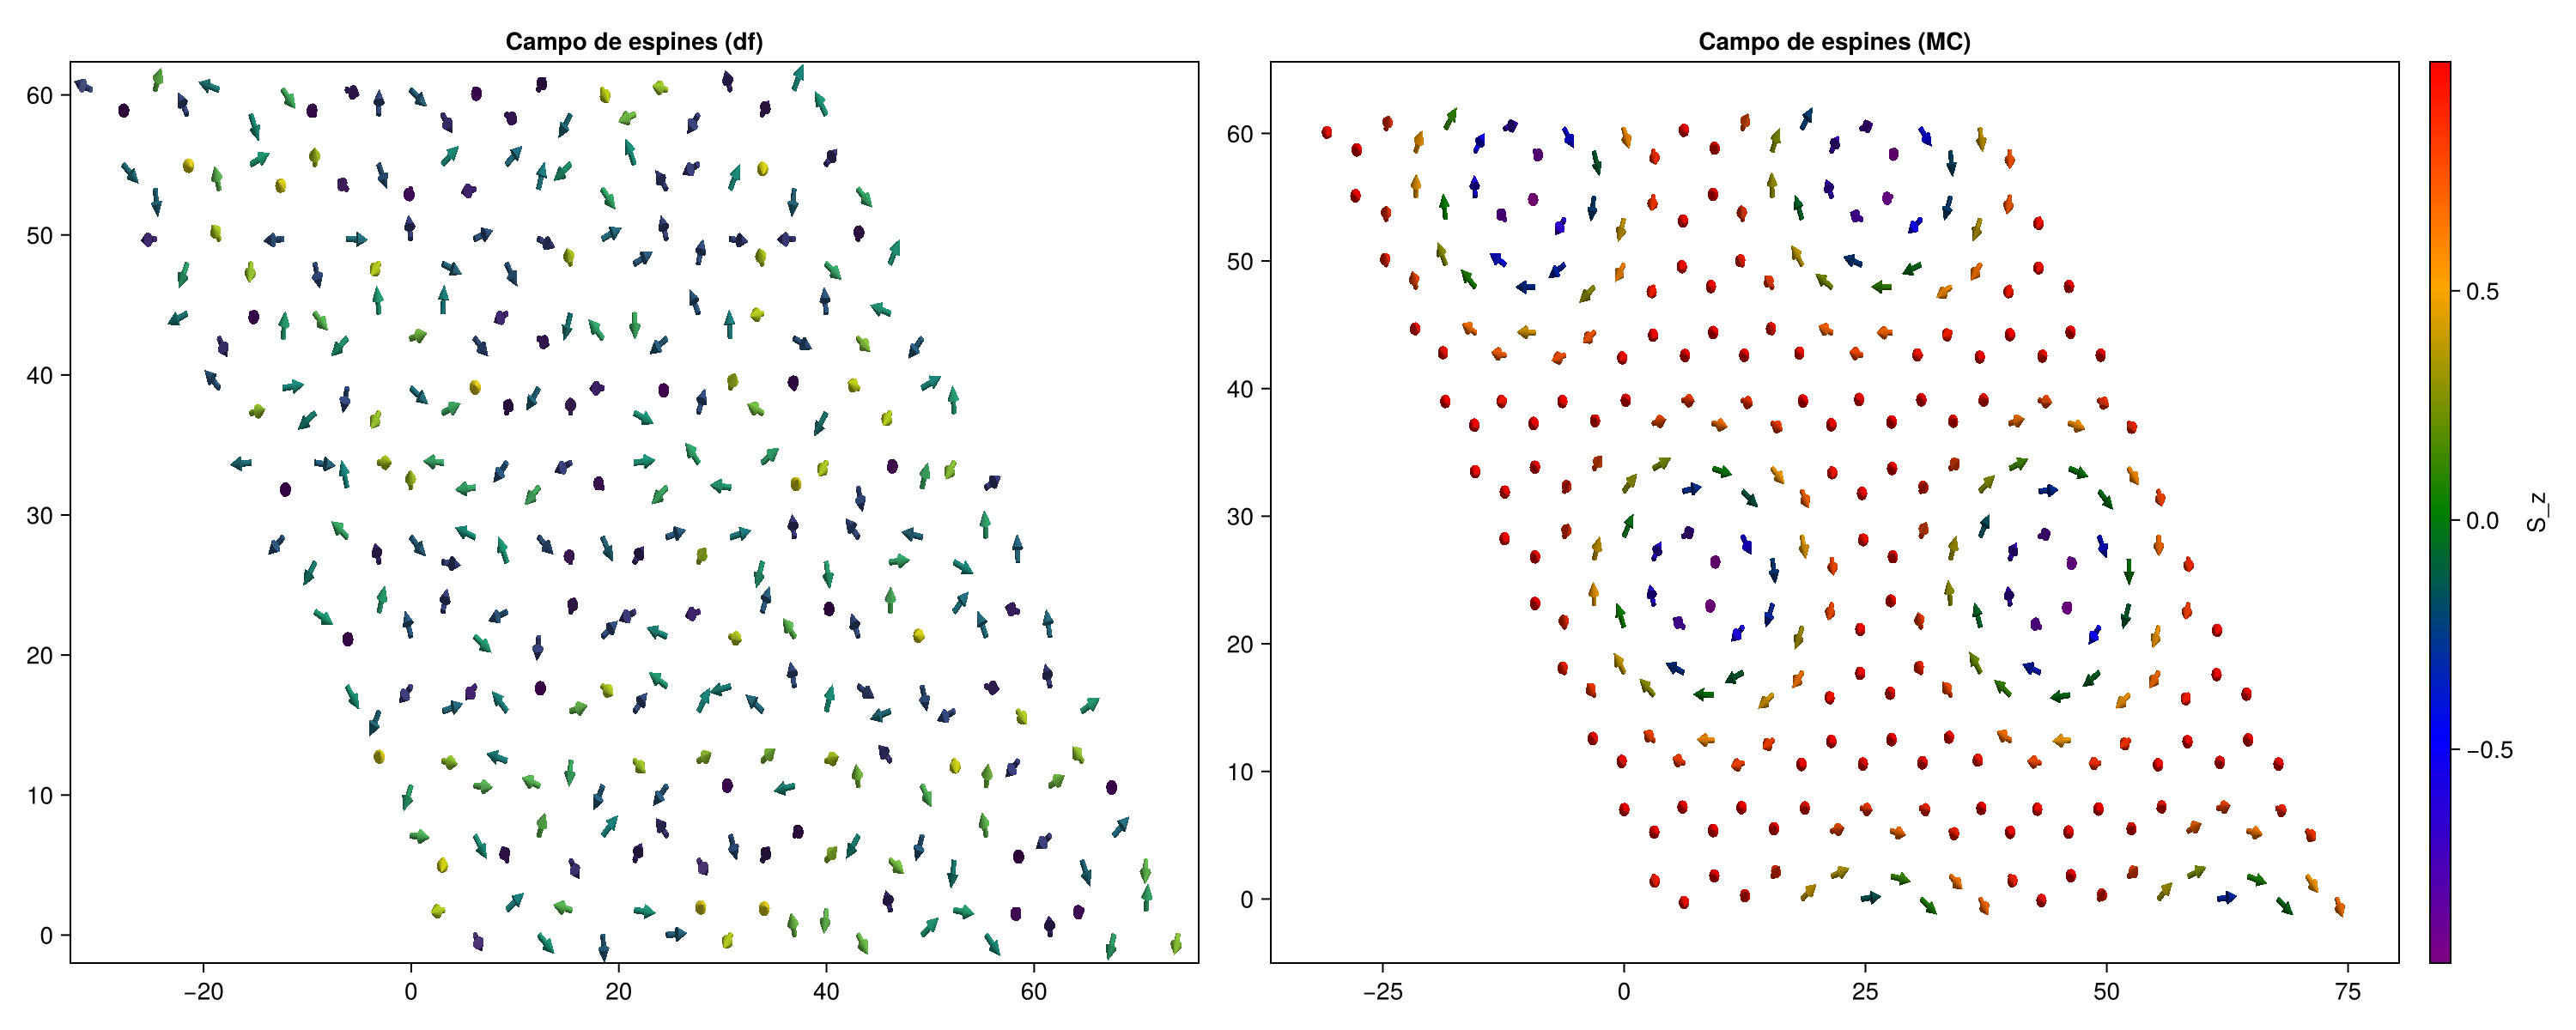

In [10]:
using CairoMakie

n = length(df_coords.x)
pad = 2
spin_scale = 2

fig = Figure(size = (1500, 600))

ax1 = Axis(
    fig[1, 1],
    # aspect = DataAspect(),
    title = "Campo de espines (df)",
    xgridvisible = false,
    ygridvisible = false
)

ax2 = Axis(
    fig[1, 2],
    # aspect = DataAspect(),
    title = "Campo de espines (MC)",
    xgridvisible = false,
    ygridvisible = false
)


arrows!(
    ax1,
    df_coords.x, df_coords.y, df_coords.z,         # posiciones
    df_coords.sp_x, df_coords.sp_y,df_coords.sp_z;    # componentes del vector
    color = df_coords.sp_z,            # escalar para colorear
    colormap = :viridis,
    lengthscale = spin_scale,
    shaftradius = 0.2,     # <-- COLA visible
    tipradius   = 0.5,
    tiplength   = 1
)


# === Gráfico 2 (guardar el handle) ===
arrows_plot = arrows!(
    ax2,
    POS[:, 1], POS[:, 2],POS[:,3],
    SP[:, 1], SP[:, 2],SP[:,3];
    color = SP[:,3],
    colormap = :rainbow,
    lengthscale = spin_scale,
    shaftradius = 0.2,     # <-- COLA visible
    tipradius   = 0.5,
    tiplength   = 1
)

# Límites idénticos
xlims = extrema(df_coords.x) .+ (-pad, pad)
ylims = extrema(df_coords.y) .+ (-pad, pad)

xlims!(ax1, xlims); ylims!(ax1, ylims)

# === Colorbar correctamente asociada ===
Colorbar(
    fig[1, 3],
    arrows_plot,
    label = "S_z"
)

fig
